# CFRM 521 - Final Report

#### By: Wooseok (Jeff), Max, Steve, Ilse, Jasmine

----

# Introduction
Pricing options is an essential task for financial institutions to assess the fair value and risk associated with these instruments. Accurate pricing supports informed investment decisions and enables effective hedging strategies, while inaccurate pricing can lead to inefficient hedging and potentially severe financial losses. Although option pricing can be complex, even relatively simple models can achieve a high degree of accuracy in certain scenarios. Several well-established models exist for pricing options, including the Black-Scholes model, the Heston model, and Dupire’s local volatility model. More recently, the rise of machine learning has spurred a growing body of research focused on using data-driven methods—such as neural networks, support vector regression, and decision trees—for option pricing. In this paper, we investigate the efficacy of several common machine learning techniques in pricing American call options and demonstrate that even simple models can yield promising results.

# Data

In [6]:
# Load the packages (at the end we can consolidate all the packages we individually used here so that we can create a single environment.yml file for a conda environment at the end)
import pandas as pd 
import numpy as np 
import os
import requests
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from scipy.stats import uniform, loguniform
import time
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Read in the data (this section should be the same for everyone)
url = "https://api.github.com/repos/stevedemirev/CFRM521-ProjectData/contents/filtered"
response = requests.get(url)
files = response.json()

csv_files = sorted([file for file in files if file['name'].endswith('.csv')], key = lambda x: x['name'])

def get_datasets(files):
    df = pd.DataFrame()
    for file in files:
        temp = pd.read_csv(file['download_url'])
        df = pd.concat([df, temp], ignore_index = True)
    return df

full_df = get_datasets(csv_files)
full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Filter to Calls Only
full_df = full_df[full_df['type'] == "call"]
# Filter to every 10th row
full_df = full_df.iloc[::10]

total_files = len(full_df)
train_size = int(total_files*0.7)
val_size = int(total_files*0.85)

train = full_df[:train_size]
valid = full_df[train_size:val_size]
test = full_df[val_size:]

def define_features(df):
    df['expiration'] = pd.to_datetime(df['expiration'])
    df['quote_date'] = pd.to_datetime(df['quote_date'])
    df['tte'] = (df['expiration'] - df['quote_date']).dt.days / 252
    X = df[['close', 'strike', 'delta', 'gamma',
            'vega', 'theta', 'implied_volatility', 'tte']]
    y = df['mid_price']
    return X, y

def get_features():
    X_feats = []
    y_feats = []
    for df in [train, valid, test]:
        df = df.copy()
        X, y = define_features(df)
        X_feats.append(X)
        y_feats.append(y)
    return X_feats, y_feats

X_feats, y_feats = get_features()
X_train, X_valid, X_test = X_feats
y_train, y_valid, y_test = y_feats

In [ ]:
display(train.head())

In [ ]:
display(train.tail())

In [5]:
total_size = len(train) + len(valid) + len(test)
def proportion(df):
    return round(len(df)/total_size,3)
    
print(f"Length of Training set: {len(train):,} rows, Proportion: {proportion(train)}")
print(f"Length of Validation set: {len(valid):,} rows, Proportion: {proportion(valid)}")
print(f"Length of Testing set: {len(test):,} rows, Proportion: {proportion(test)}")
print(f"Original Dataset size: {total_size:,} rows, Sum Check: {proportion(train)+proportion(valid)+proportion(test)}")

Length of Training set: 24,161 rows, Proportion: 0.7
Length of Validation set: 5,178 rows, Proportion: 0.15
Length of Testing set: 5,178 rows, Proportion: 0.15
Original Dataset size: 34,517 rows, Sum Check: 1.0


# Max Black: SVR

The model for this section will be support vector regression. We chose support vector regression because we complex non-linear relationships in our pricing model. Support vector regression is an excellent candidate for this task, but does have a few drawbacks. Support vector regression scales very slowly with the number of data entries, which means we are limited by our hardware for the purposes of this project. Running on more than around 30,000 data points triggers runtimes that makes optimizing hyperparameters extremely difficult and mostly impractical. 

Prior to training our support vector regressor, we will train a naive model that predicts each point to be the mean of our training data. We expect our fully fitted and optimized support vector regressor to outperform this considerably. In order to show this, we will be using mean squared error as our core loss function, but will also examine mean absolute error so we can tell how much outliers are impacting the results. We will also analyze residuals to better understand overall model performance. 

In [4]:
# feature_cols = ['close', 'strike', 'delta', 'gamma',
#                 'vega', 'theta', 'implied_volatility', 'tte']

# X_train = train[feature_cols]
# y_train = train['mid_price']

# X_valid = valid[feature_cols]
# y_valid = valid['mid_price']

# X_test = test[feature_cols]
# y_test = test['mid_price']

KeyError: "['tte'] not in index"

We will start by training a standard scaler on our training data, and applying it to the validation and test sets. Fields like stock price and strike price are much larger in scale than our other variables, so this is particularly important here, but we generally would want to apply a standard scaler to our predictors before an support vector regression.

In [7]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

## Naive Model

To determine the efficacy of our support vector regression we will train a naive model first, using the mean of our training data. As mentioned before, this model predicts every point to be the mean of the training data. 

In [8]:
dummy = DummyRegressor(strategy='mean')

Below is a function to plot learning curves for mean absolute error and root mean squared error. It is based on a function introduced in lecture, but adjusted to reduce the number of plotted points. Support vector regression is a very slow process, and plotting a learning curve with a different training set for every entry in the training set, which is what the original function did, is impractical, especially considering the size of our data. For the naive model though, this is not a problem. 

In [9]:
def plot_learning_curves(model, X_train, y_train, X_val, y_val, n_points=50):
    train_sizes = np.linspace(10, len(X_train), n_points, dtype=int)
    
    train_rmse, val_rmse = [], []
    train_mae, val_mae = [], []

    for m in train_sizes:
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)

        train_rmse.append(np.sqrt(mean_squared_error(y_train[:m], y_train_predict)))
        val_rmse.append(np.sqrt(mean_squared_error(y_val, y_val_predict)))

        train_mae.append(mean_absolute_error(y_train[:m], y_train_predict))
        val_mae.append(mean_absolute_error(y_val, y_val_predict))

    fig, axs = plt.subplots(1, 2, figsize=(10, 7))

    axs[0].plot(train_sizes, train_rmse, "r-+", linewidth=2, label="Train")
    axs[0].plot(train_sizes, val_rmse, "b-", linewidth=3, label="Validation")
    axs[0].set_title("Learning Curve (RMSE)", fontsize=14)
    axs[0].set_xlabel("Training set size", fontsize=12)
    axs[0].set_ylabel("RMSE", fontsize=12)
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(train_sizes, train_mae, "r-+", linewidth=2, label="Train")
    axs[1].plot(train_sizes, val_mae, "b-", linewidth=3, label="Validation")
    axs[1].set_title("Learning Curve (MAE)", fontsize=14)
    axs[1].set_xlabel("Training set size", fontsize=12)
    axs[1].set_ylabel("MAE", fontsize=12)
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

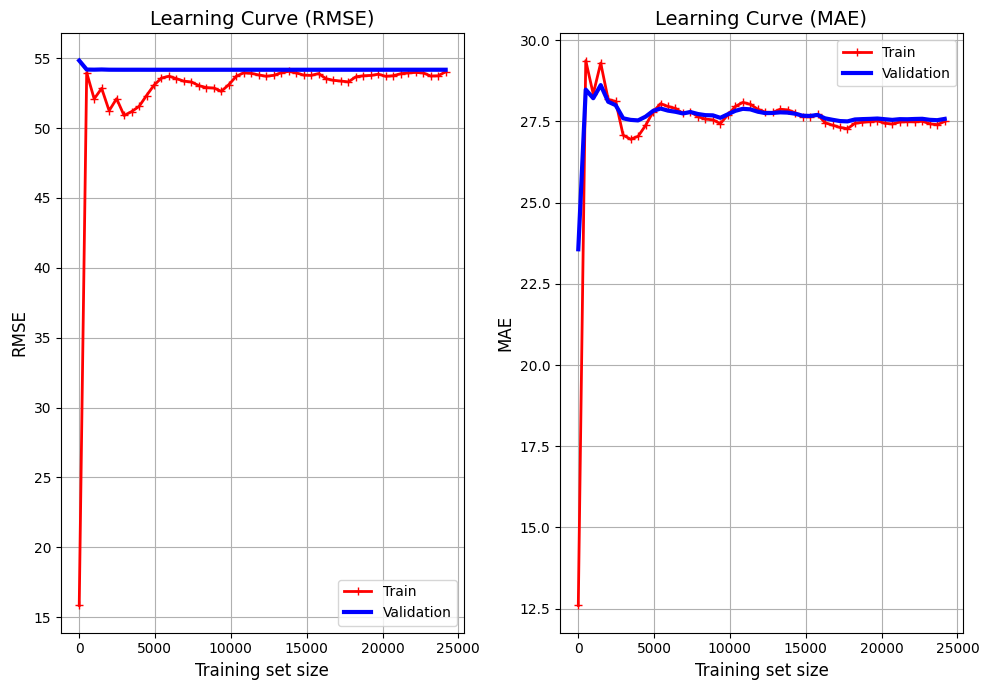

In [10]:
plot_learning_curves(dummy, X_train_scaled, y_train, X_valid_scaled, y_valid, n_points=50)

From these results, we can clearly see that the naive model is underfitting the data. The RMSE and MAE do appear to converge, but to large values of RMSE and MAE. 

Below we plot the actual and predicted values of the naive model along with the MSE and MAE of our naive model on the test set. 


Test MSE: 2993.0309
Test MAE: 27.7149


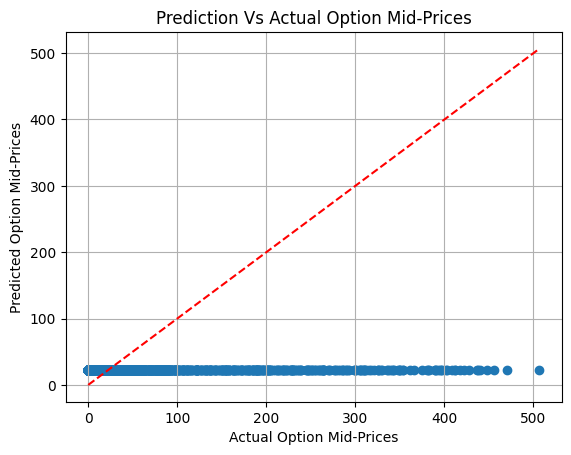

In [11]:
y_pred_test_dummy = dummy.predict(X_test_scaled)

mse_dummy = mean_squared_error(y_test, y_pred_test_dummy)
mae_dummy = mean_absolute_error(y_test, y_pred_test_dummy)

print(f"\nTest MSE: {mse_dummy:.4f}")
print(f"Test MAE: {mae_dummy:.4f}")

plt.scatter(y_test, y_pred_test_dummy)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Option Mid-Prices")
plt.ylabel("Predicted Option Mid-Prices")
plt.title("Prediction Vs Actual Option Mid-Prices")
plt.grid(True)
plt.show()

The predicted prices are constant throughout as expected. Clearly this does a poor job of estimating our option prices. We can further see that the test MSE and MAE are extremely high. 

Below we plot the distribution of the model residuals.

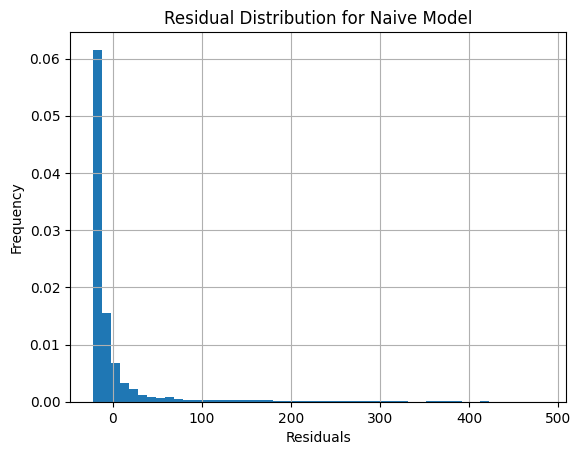

In [12]:
residuals_dummy = y_test - y_pred_test_dummy
plt.hist(residuals_dummy, bins=50, density=True)
plt.title("Residual Distribution for Naive Model")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

We can see that the residuals have a positive skew, meaning that the majority of the estimates of the naive model are below the true option prices.

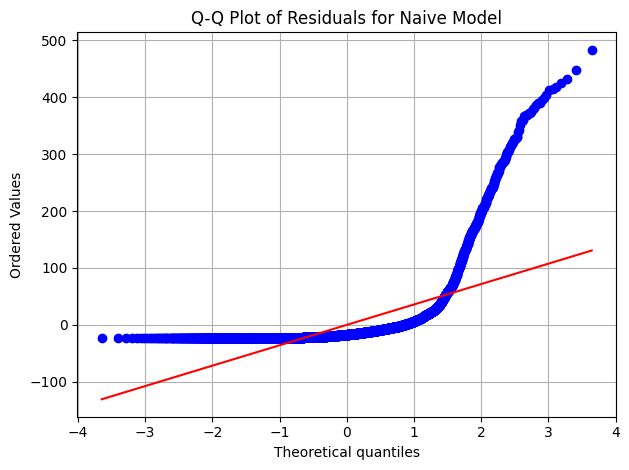

In [13]:
stats.probplot(residuals_dummy, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals for Naive Model")
plt.grid(True)
plt.tight_layout()
plt.show()

From the QQ-plot above we can see that the residuals are clearly not normally distributed. As we saw in the histogram there is a positive skew.
## Support Vector Regression

We will run a quick pilot study to narrow our search down to one kernel. Ideally would would explore each of them more, but given the complexity of our data structure we are confident that the RBF kernel will be most effective. This is most commonly used when pricing options with SVR, as seen in Wang and Zhang (2010) and Andreou et Alias (2009). We will test each kernel with default hyperparameters to ensure that the RBF kernel is outperforming other kernels, but will not examine this further. 

In [14]:
kernels = ['linear', 'poly', 'sigmoid', 'rbf',]
results = {}

for kernel in kernels:
    print(f"\nSVR with {kernel} Kernel")

    model = SVR(kernel=kernel, C=1.0, epsilon=0.1)

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_valid_scaled)

    mse = mean_squared_error(y_valid, y_pred)

    mae = mean_absolute_error(y_valid, y_pred)

    results[kernel] = {'MSE': mse, 'MAE': mae}
    print(f"Validation MSE: {mse:.4f}")
    print(f"Validation MAE: {mae:.4f}")


SVR with linear Kernel
Validation MSE: 862.4484
Validation MAE: 10.1338

SVR with poly Kernel
Validation MSE: 485.2563
Validation MAE: 9.0620

SVR with sigmoid Kernel
Validation MSE: 79090.0403
Validation MAE: 134.4501

SVR with rbf Kernel
Validation MSE: 349.9289
Validation MAE: 5.4849


Based on these results, we can see that our SVR performed best using the RBF kernel, as we expected. The difference is significant by all metrics.

Now that we have analyzed our different kernels and arrived at RBF, we will move on to tuning the hyperparameters to see if it significantly improves the accuracy. For hyperparameter tuning we are going to utilize the random search method. We are working with 3 parameters that can take on a continuous range of values. To briefly summarize each of the parameters

- $C$ controls the degree to which margin violations are penalized
- $\varepsilon$ controls the margin of error that we ignore
- $\gamma$ controls how 'local' the decision boundary is

Each of three parameters can take the value of any postive real number. Below we test a range of these values with the RBF kernel. 

In [15]:
model_rbf = SVR(kernel='rbf')

param_distributions = {
    'C': loguniform(1e-1, 1e3),       
    'gamma': loguniform(1e-4, 1),      
    'epsilon': uniform(0.01, 0.3)    
}

search = RandomizedSearchCV(
    model_rbf,
    param_distributions=param_distributions,
    n_iter=50,             
    scoring='neg_mean_squared_error',
    cv=3,                    
    n_jobs=-1,              
    random_state=42
)

search.fit(X_train_scaled, y_train)

print("Best Parameters Found:")
print(search.best_params_)

print("\nBest CV MSE:", -search.best_score_)

y_pred = search.predict(X_valid_scaled)
mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)

print(f"\nValidation MSE: {mse:.4f}")
print(f"Validation MAE: {mae:.4f}")

Best Parameters Found:
{'C': np.float64(624.5139574743067), 'epsilon': np.float64(0.2996896099223678), 'gamma': np.float64(0.17123375973163968)}

Best CV MSE: 4.155204154630549

Validation MSE: 1.7905
Validation MAE: 0.2743


As we can see the high $C$ value, this model penalizes errors severely. Still it selects a relatively high epsilon of 0.3, so it allows for some margin of error. The model selects a moderate gamma, not making decisions boundary too local, and allowing the model to generalize slightly more. 

Below we call the function to generate learning curves for our SVR regressor with the RBF kernel and optimized hyperparameters. We can see already from the result above that this model performs well on the validation sets, with MSE of about 1.8 and MAE error of less than 0.3. Recall from our naive model that the MSE was nearly 3000, so this result is encouraging. Note that the validation data shown in the plots below is from the mean across our 3 cross-validation folds in the training data, not the validation dataset that we seperated at the beginning. The validation set predictions are meant to give us some idea about model performance at this stage. 

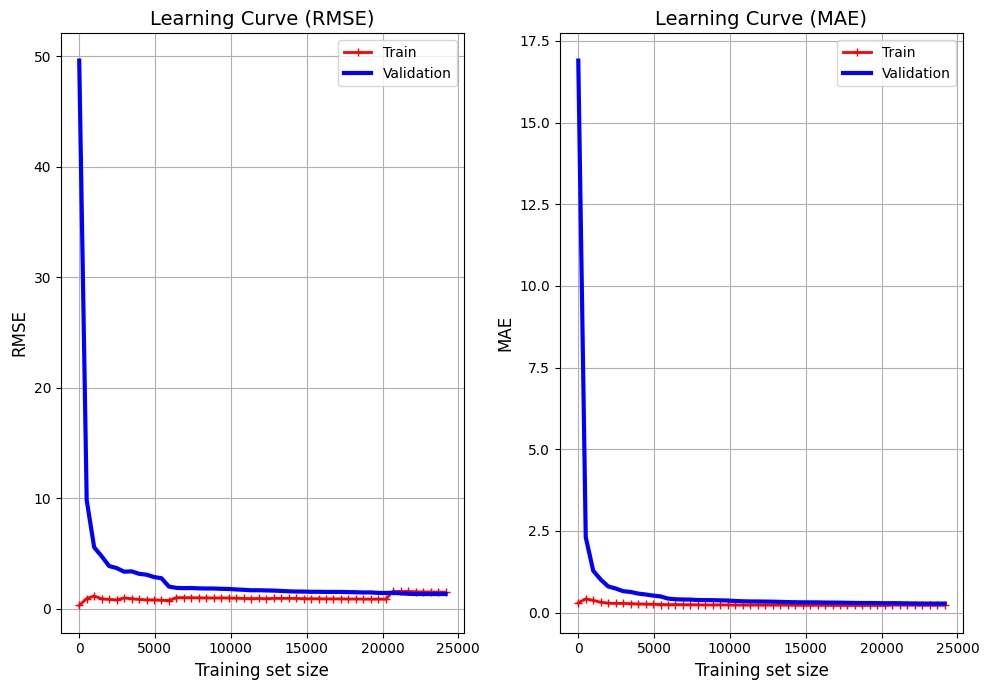

In [16]:
best_model_plot = SVR(kernel='rbf', **search.best_params_)

plot_learning_curves(best_model_plot, X_train_scaled, y_train, X_valid_scaled, y_valid)

Now we can determine the results of running this support vector regression on our test data. 

We can see that the errors decrease rapidly as training size increases, with an elbow beginning at around 1000 data points. The validation and training sets RMSE and MAE converge to very lower values, with minimal seperation between the two lines. This indicates that our model is neither overfitting or underfitting. 

In [17]:
best_model = search
y_pred_test = best_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"\nTest MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")


Test MSE: 3.0602
Test MAE: 0.2814


The results from our test data show a MSE of about 3, which is a strong result. We saw that our naive data had a MSE of nearly 3000, so clearly the support vector regressor with RBF kernel is outperformming that. The MAE is only about 0.28, which suggests that the results from our MSE are being impacted heavily by outliers. We will now look at how the residuals from the support vector regressor behave. 

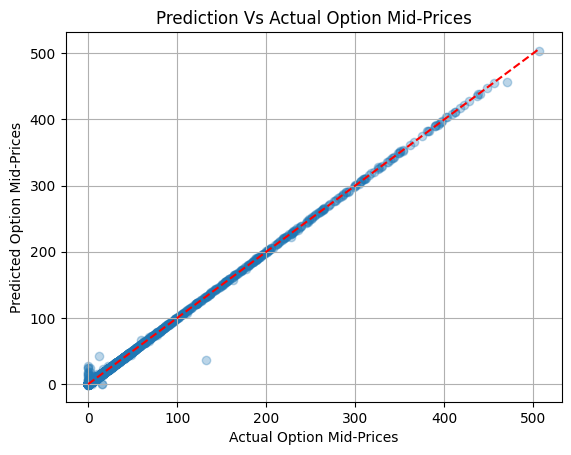

In [18]:
plt.scatter(y_test, y_pred_test, alpha = 0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Option Mid-Prices")
plt.ylabel("Predicted Option Mid-Prices")
plt.title("Prediction Vs Actual Option Mid-Prices")
plt.grid(True)
plt.show()

From this plot of the predicted vs actual option prices we can see that the every point is close to the actual values. There appears to be some more variance in results closer to zero, but for higher prices the results appear to perform consistently very well. There are a few outliers, most notably at an actual price of around 130, which could be having a large impact on our MSE, as the actual and predicted price appear to have a difference of about 100. Most of the other errors seem to be clustered very close to the actual price of 0. 

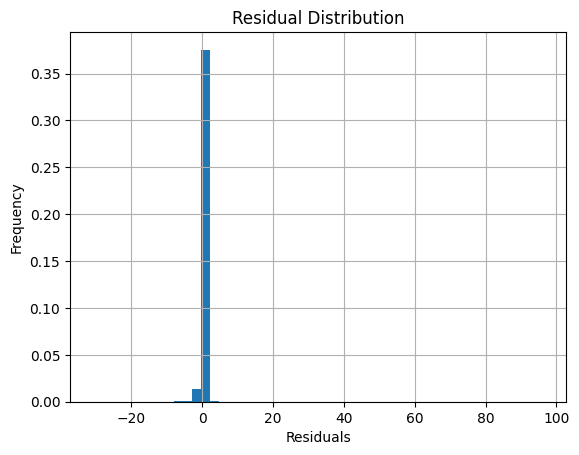

In [19]:
residuals = y_test - y_pred_test
plt.hist(residuals, bins=50, density=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

From this plot of our residuals, we can see that the vast majority are clustered around zero. This is a good sign, and tells use that our support vector regression likely does not have a positive or negative skew. 

Below we also plot a QQ-plot. Note that there is no assumption of normality of error terms in support vector regression, like there is in linear regression, so we dont actually expect the errors to be normally distributed. We are only doing this to better understand the distribution of the residuals. 

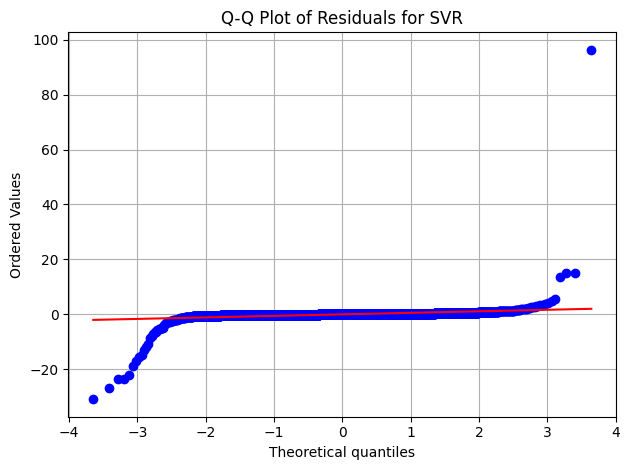

In [20]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals for SVR")
plt.grid(True)
plt.tight_layout()
plt.show()

We can see that there are significantly heavier postive and negative tails than you would typically see in a normal distribution. This makes sense, because the model is indifferent to small residuals that fall inside the band created by the hyperparameter $\varepsilon$. In fact the MAE was about 0.28, which was very close to the value of $\varepsilon$m which was about 0.3. This means that residuals can spread out freely near the edge of this bounadary, making the distribution have significantly heavier tails than a normal distribution. This behavior is expected, but is a downside of the model. The width of epsilon could become more significant of a factor for options that have a low prices point. In fact we saw that to some degree when we plotted the actual and predicted values against one another. At lower price points there was a more obvious spread, which suggests that this band was having a noticable impact on the predicted price. We need to be very careful when using it to price extremely low price options, because in those price ranges the band created by epsilon is much more noticable. 

Overall this model is very promising, but has could have issues modeling options in low price ranges. Still it performs very constitently throughout the training, validation and test sets, and generates a low MSE and MAE for the test set, which indicates it is able to price these options effectively. There was only 1 extreme outlier in our results, which suggests that it performs consistently. The MSE was boosted by some outliers, but with MAE was low, around 0.3. 

## References

Wang, J., & Zhang, J. (2010). Stock trend prediction based on a new status box method. Expert Systems with Applications, 37(8), 5640–5649. https://doi.org/10.1016/j.eswa.2010.02.094

Andreou, P. C., Charalambous, C., & Martzoukos, S. H. (2010). European option pricing by using the support vector regression approach. In Artificial Intelligence Applications and Innovations (pp. 247–256). Springer. https://doi.org/10.1007/978-3-642-16239-8_26

----

# Wooseok's Model

----

# Steve's Model

## Baseline Model

For my model's architecture, I decided to use 4 hidden layers with 50 neurons each with 'ReLU' activation, 'he_normal' initializer, 'Nadam' optimizer, early stopping with a patience of 10, and "MSE" as the primary loss metric, and "MAE" as the secondary loss metric. The choice to use 4 hidden layers with 50 neurons was somewhat arbitrary and not backed by any theoretical justification other than the expectation of it being able to accurately capture any non-linear relationships occuring with options pricing. The output layer would remain the default linear activation function with one neuron as we are expecting a single value, the mid price. I also chose the "ReLU" activation function for each neuron with "he_normal" initializer to better model the non-linear relationship and avoid vanishing gradients during training. Additionally, "ReLU" works well because it encourages positive only outputs, which matches with the intrinsic value of an option is defined as: $V = \text{max}(S_T - K, 0)$. The 'Nadam' optimizer was chosen here as its learning rate is adaptable, allowing it to converge faster and smoother for non-linear functions compared to other optimizers. Early stopping was added as a form of regularization to prevent unnecessary training once the model stops improving on the validation set. Given the time required to train the model, early stopping is an effective way to reduce training time while also helping to avoid overfitting. Since the objective of this project is to predict option prices, Mean Squared Error (MSE) and Mean Absolute Error (MAE) are appropriate evaluation metrics. MSE penalizes larger errors more heavily, making it useful for identifying significant prediction deviations, while MAE provides a more interpretable measure of the average prediction error.

In [ ]:
def define_features(df):
    df['expiration'] = pd.to_datetime(df['expiration'])
    df['quote_date'] = pd.to_datetime(df['quote_date'])
    df['tte'] = (df['expiration'] - df['quote_date']).dt.days / 252
    X = df[['close', 'strike', 'delta', 'gamma',
            'vega', 'theta', 'implied_volatility', 'tte']]
    y = df['mid_price']
    return X, y

def get_features():
    X_feats = []
    y_feats = []
    for df in [train, valid, test]:
        df = df.copy()
        X, y = define_features(df)
        X_feats.append(X)
        y_feats.append(y)
    return X_feats, y_feats

X_feats, y_feats = get_features()
X_train, X_valid, X_test = X_feats
y_train, y_valid, y_test = y_feats

In [ ]:
def scale_data(train, val, test):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    valid_scaled = scaler.transform(val)
    test_scaled = scaler.transform(test)
    return train_scaled, valid_scaled, test_scaled

def reset_session(seed=42):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def build_model(input_shape):
    reset_session()
    model = tf.keras.Sequential([
        tf.keras.Input(shape = (input_shape,)),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(
        optimizer = "nadam",
        loss = "mse",
        metrics = ['mae']
    )
    return model

X_train_scaled, X_valid_scaled, X_test_scaled = scale_data(X_train, X_valid, X_test)

early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    mode = "min",
    restore_best_weights = True
)

In [ ]:
model = build_model(X_train_scaled.shape[1])

start = time.time()
history_baseline = model.fit(X_train_scaled, y_train,
             validation_data = (X_valid_scaled, y_valid),
             epochs = 50, verbose = 1, callbacks=[early_stop])
end = time.time()
baseline_time = end-start

mse_val, mae_val = model.evaluate(X_valid_scaled,
                                        y_valid, verbose = 0)
test_loss, test_mae = model.evaluate(X_test_scaled,
                                        y_test, verbose = 0)

print("\Baseline Model:")
print(f"Validation MSE: {mse_val}")
print(f"Validation MAE: {mae_val}")

print(f"\nTest MSE: {test_loss}")
print(f"Test MAE: {test_mae}")

In [ ]:
def plot_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6))

    ax1.plot(history.epoch, history.history["loss"], '*-', label="Training Loss", color='b')
    ax1.plot(history.epoch, history.history["val_loss"], '--', label="Validation Loss", color='b')
    ax1.set_title("Training vs Validation Loss (MSE) for Call Options")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss (MSE)")
    ax1.grid(True)
    ax1.legend()
    
    ax2.plot(history.epoch, history.history["mae"], '*-', label="Train MAE", color='r')
    ax2.plot(history.epoch, history.history["val_mae"], '--', label="Val MAE", color='r')
    ax2.set_title("Training vs Validation MAE for Call Options")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Mean Absolute Error")
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_learning_curves(history_baseline)

As we can see from the learning curves above, the training loss and the validation loss converge closely, suggesting that the model is learning effectively without overfitting. We can also confirm this by looking at the training and validation MAE which also converges.

In [ ]:
def get_prediction_plot(model, X_test_s, y_test):
    y_pred = model.predict(X_test_s)
    
    residuals = y_test - y_pred.flatten()
    plt.scatter(y_test, y_pred, marker = 'o', alpha = 0.3)
    plt.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Option Mid-Prices")
    plt.ylabel("Predicted Option Mid-Prices")
    plt.title(f"Prediction Vs Actual Call Option Mid-Prices")
    plt.grid(True)
    plt.show()
    return residuals

residuals = get_prediction_plot(model, X_test_scaled, 
                    y_test)

This plot allows us to visualize how well the model predicted the mid-price of the option, with a perfectly diagonal line indicating all the predictions were completely accurate. The model does seem to follow this diagonal line but there is a noticeable deviation around 0 where predictions seem to be less accurate.

In [ ]:
residuals.name = "residuals"
display(residuals.to_frame().describe())

The summary statistics of the residuals show that the model’s average error is close to zero, indicating that, on average, the predicted option prices closely match the actual values. The standard deviation of approximately 1.26 suggests that most prediction errors fall within ±1.26 of the true option price. However, the model’s largest error exceeded 33 dollars over prediction, revealing the presence of significant outliers and suggesting there is room for further improvement in handling extreme cases.

In [ ]:
plt.hist(residuals, density=True, bins = 1000)
plt.axvline(residuals.mean(), color='r', linestyle='--', label='Mean')
plt.xlim(-3,3)
plt.legend()
plt.show()

In [ ]:
stats.probplot(residuals, dist = "norm", plot = plt)
plt.title("QQ Plot of Residuals")
plt.grid(True)
plt.show()

As we can see from the two plots above, while the histogram looks normally distributed, the QQ-plot tells us that it is in fact not normally distributed. If the residuals were normally distributed, then it would form a diagonal line, but here the tail ends significantly deviate from the diagonal line, indicating that the tails are heavier than those of a normal distribution.

## Hyperparameter search

To optimize the Neural Network model, we want to identify the best hyperparameter configuration which predicts the option's `mid_price` closest, to do this I will implement a randomized search. 

A few of the hyperparameters to optimize are: 
* Number of Hidden Layers
* Number of Neurons per layer
* Neuron activation function
* Neuron l2 regularization
* Learning rate
* Optimizer

To find the best configuration, we will select the number of hidden layers between 1 and 5, as adding more may be redundant. For the number of neurons, we will select a value between 10 and 100 neurons. Since deep neural networks often perform better with 'swish' activation rather than with 'ReLU', we will select the activation function between those two at random to assess which performs better. Our l2 regularizer and learning rate will both be chosen from a range between 1e-6 and 1e-2 to allow a broader range of values in which to assess performance on. Lastly, the optimizer will be selected at random as either the 'Adam' optimizer or the adam optimizer with nesterov momentum ('Nadam') to assess which fits the model better. Once again we will include early stopping to avoid unneccessary training, but this time with a patience of 5, as we will only be training on 20 epochs instead of 50 due to time constraints. This randomized search will run for 30 iterations in order to assess the optimal parameters, which we will then compare the best model here against the baseline model on their test set performance.

In [ ]:
def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

def build_model(hp):
    reset_session()

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = (X_train.shape[1],)))

    n_hidden = hp.Int("n_hidden", 1, 5)
    for i in range(n_hidden):
        model.add(tf.keras.layers.Dense(
            hp.Int(f"n_neurons_{i+1}", 10, 100),
            activation = hp.Choice("activation", ["relu", 'swish']),
            kernel_regularizer = tf.keras.regularizers.l2(
            hp.Float("l2", 1e-6, 1e-2, sampling="log")
            ),
            kernel_initializer = "he_normal"
        ))
        
    model.add(tf.keras.layers.Dense(1))
    
    learning_rate = hp.Float("learning_rate", 1e-6, 1e-2, sampling = "log")
    optimizer_name = hp.Choice("optimizer", ["Adam", "Nadam"])
    
    if optimizer_name == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
  
    model.compile(loss="mse", metrics = ['mae'], optimizer=optimizer)
    return model

early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    mode = "min",
    restore_best_weights = True
)

In [ ]:
random_search_tuner = kt.RandomSearch(
    build_model, 
    objective = "val_loss", 
    seed = 42, 
    max_trials = 30, 
    overwrite = True
)

random_search_tuner.search(X_train_scaled, y_train, epochs = 20, 
                    validation_data = (X_valid_scaled, y_valid), verbose = 1,
                          callbacks=[early_stop])

In [ ]:
best_hyperparams = random_search_tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hyperparams.values

In [ ]:
best_model = build_model(best_hyperparams)

start = time.time()
history_best = best_model.fit(X_train_scaled, y_train,
             validation_data = (X_valid_scaled, y_valid),
             epochs = 50, verbose = 1, callbacks=[early_stop])
end = time.time()
tuned_model_time = end - start

test_loss_best, test_mae_best = best_model.evaluate(X_test_scaled, y_test)
print("\nTest MSE:", test_loss_best)
print("Test MAE:", test_mae_best)

In [ ]:
plot_learning_curves(history_best)

In [ ]:
residuals = get_prediction_plot(best_model, X_test_scaled, 
                    y_test)

In [ ]:
plt.hist(residuals, density=True, bins = 1000)
plt.axvline(residuals.mean(), color='r', linestyle='--', label='Mean')
plt.xlim(-3,3)
plt.legend()
plt.show()

In [ ]:
stats.probplot(residuals, dist = "norm", plot = plt)
plt.title("QQ Plot of Residuals")
plt.grid(True)
plt.show()

In [ ]:
results_df = pd.DataFrame([
    {
        'Model': 'Baseline',
        'Layers': 4,
        'Activation': "relu",
        'Optimizer': "Nadam",
        'Epochs': max(history_baseline.epochs)+1,
        'Test MAE': round(test_mae, 4),
        'Test MSE': round(test_loss, 4),
        'Train Time (s)': round(baseline_time, 2)
    },
    {
        'Model': 'Tuned',
        'Layers': int(best_hyperparams['n_hidden']),
        'Activation': str(best_hyperparams['activation']),
        'Optimizer': str(best_hyperparams['optimizer']),
        'Epochs': max(history_best.epoch)+1,
        'Test MAE': round(test_mae_best, 4),
        'Test MSE': round(test_loss_best, 4),
        'Train Time (s)': round(tuned_model_time, 2)
    }
])

display(results_df)

As we can see from the plots above, the hyperparameter tuned model also doesn't seem to be overfitting as the training loss metrics converge nicely with the validation losses. The predictions seem to be slightly worse compared to the baseline model as we encounter more incorrectly estimated values around 0, this can be reinforced from the test MSE and test MAE which were higher compared to the baseline model. 

Regardless, the hyperparameter tuned model seemed to use the same activation function and optimizer as our baseline model did, possibly indicating these were better parameters than "swish" activation and "adam" optimizer we were evaluating against. The number of hidden layers in the tuned model was also less than the baseline model, which allowed for a slightly faster training speed at the cost of slightly worse predictions. 

In summary, the hyperparameter optimization did not yield a significant improvement over our initial model architecture. This suggests that the baseline model was already well-suited for the task. For future work, we could build upon the baseline model by performing another randomized search, but this time focusing only on optimizing the l2 regularization and the learning rate parameters which could further improve the model's performance.

----

# Ilse's Model

In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

## Gradient Boost

For my model, I chose Gradient Boosting for it's popularity in machine learning applications and it's relative speed compared to other more intensive models. Gradient boost focuses on fitting new predictors to residual errors made by the previous iteration, making it ideal for predicting the price of options. 

Starting with an initial model, we can generate a basic model with certain inital features, and see how good of a fit we get. We pick the inital features based on prior knowledge of Gradient Boosting regressors, as well as unseen iteration of the model to get a decent fit that runs in decent time. This method is not scientifically sound, but given the scope of the project, is used to better manage storage and time concerns. 

We expect the mean squared and mean absolute error to be better for the final model, but in the meantime, we can see how how the model behaves. 

In [6]:
gbrt = GradientBoostingRegressor(max_depth=5,
                                 n_estimators=120,
                                 learning_rate=0.5,
                                 n_iter_no_change=5,
                                 random_state=42)
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_test)

In [7]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error of test set: {mse}')
print(f'Mean absolute error of test set: {mae}')

Mean squared error of test set: 15.217154012619384
Mean absolute error of test set: 1.8057905861580072


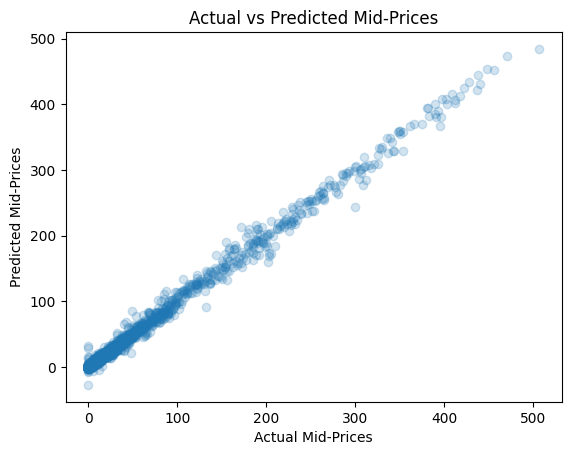

In [8]:
index = range(0, len(y_test))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel("Actual Mid-Prices")
plt.ylabel("Predicted Mid-Prices")
plt.title('Actual vs Predicted Mid-Prices')
plt.show()

## Hyperparameter search

For hyperparameter tuning, we have a couple parameters that we can adjust for a better fit. 
- **n_estimators** is the number of predictors or trees within the ensemble
- **Learning_rate** scales the effect the previous predictor has in constructing the next predictor
- **n_iter_no_change** Helps prevent overfitting. If the previous *k* predictors have not improved the error, the model is stopped early. If this hyperparameter is too large, the model will overfit nonetheless, and thus needs to be chosen carefully. 

While another method such as GridSearchCV is available for hyperparameter tuning, the more systematic way is to adjust the learning rate, and find a good value of n_estimators that minimizes the error on the validation set. Additionally, gradient boost is prone to overfitting, and this approach will help to prevent such overfitting from occuring. In order to better serve this goal, we will use both the MSE and MAE to find the best model, as the MSE may end up being skewed by outlier error and MAE can provide better insight into the best gradient boosting model. 

We begin by finding the best learning parameter, assuming we fix the all other parameters from the initial model: 

In [11]:
for l in (0.05, 0.1, 0.3, 0.5, 0.7, 1.0):
    gbrt = GradientBoostingRegressor(max_depth=5, 
                                     learning_rate=l,
                                     n_iter_no_change=5,
                                     n_estimators=120, 
                                     random_state=42
    )
    gbrt.fit(X_train, y_train)

    gbrt.staged_predict(X_valid)
    errors = [mean_squared_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
    errs = [mean_absolute_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
    best_MSE = np.min(errors)
    best_MAE = np.min(errs)
    print()
    print(f'Learning rate: {l}')
    best_n_estimators = np.argmin(errors)+1
    best_n_est = np.argmin(errs)+1
    print('min MSE: {:.4f}, number of trees: {}'
          .format(best_MSE, best_n_estimators))
    print('min MAE: {:.4f}, number of trees: {}'
          .format(best_MAE, best_n_est))


Learning rate: 0.05
min MSE: 17.1656, number of trees: 120
min MAE: 1.9258, number of trees: 120

Learning rate: 0.1
min MSE: 9.2520, number of trees: 120
min MAE: 1.4823, number of trees: 120

Learning rate: 0.3
min MSE: 9.3152, number of trees: 120
min MAE: 1.4869, number of trees: 120

Learning rate: 0.5
min MSE: 14.4942, number of trees: 72
min MAE: 1.8786, number of trees: 73

Learning rate: 0.7
min MSE: 24.7325, number of trees: 47
min MAE: 2.3652, number of trees: 47

Learning rate: 1.0
min MSE: 59.3865, number of trees: 36
min MAE: 3.3471, number of trees: 43


Learning rate 0.1 has the smallest MSE and MAE, and as such, is the learning rate that will be used going forward. Now, we fix the learning rate, begin looking for the ideal number of estimators, based on both the MSE, MAE, and the previous learning rate search. We set *n_estimators* equal to 500 to give the model plenty of trees to use.  

In [13]:
gbrt = GradientBoostingRegressor(max_depth=5, 
                                 learning_rate=0.1,
                                 n_estimators=700, 
                                 n_iter_no_change=5,
                                 random_state=42)
gbrt.fit(X_train, y_train)

gbrt.staged_predict(X_valid)



errors = [mean_squared_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
errs = [mean_absolute_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
best_MSE = np.min(errors)
best_MAE = np.min(errs)
print()
print('Learning rate: 0.1')
best_n_estimators = np.argmin(errors)+1
best_n_est = np.argmin(errs)+1
print('min MSE: {:.4f}, number of trees: {}'
          .format(best_MSE, best_n_estimators))
print('min MAE: {:.4f}, number of trees: {}'
          .format(best_MAE, best_n_est))


Learning rate: 0.1
min MSE: 4.5570, number of trees: 668
min MAE: 0.9851, number of trees: 669


From here, we have a couple differnt values we can use for the *n_estimator*. can see we have two different values for the number of trees to use in the best model. As such, we can build both models, and compare the MSE and MAE of each to see what produces the best model, and fit other hyperparameters based on this. 

In [15]:
y_pred = []
for param, i in zip([120, 668, 669], range(0, 3)):
    test_model = GradientBoostingRegressor(max_depth=5, 
                                           learning_rate=0.3,
                                           n_estimators=param, 
                                           n_iter_no_change=5,
                                           random_state=42)

    test_model.fit(X_train, y_train)
    pred = test_model.predict(X_test)
    y_pred.append(pred)


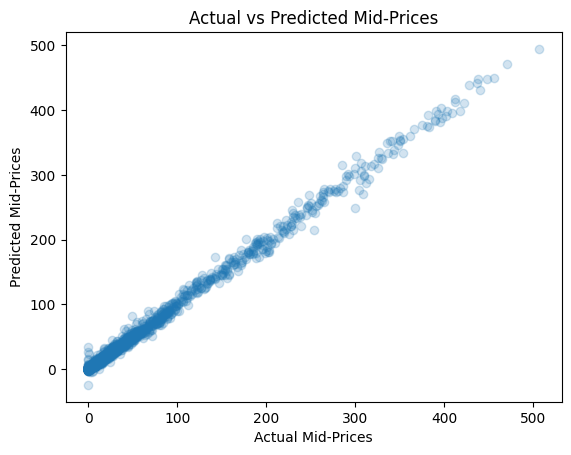

Mean squared error of test set: 10.79153965039579
Mean absolute error of test set: 1.4946342385985543


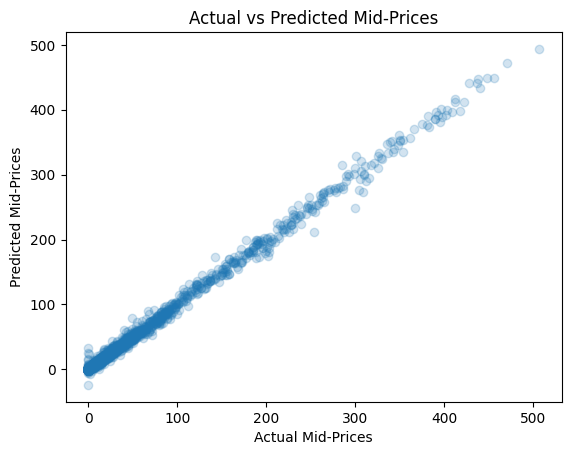

Mean squared error of test set: 9.6815022703375
Mean absolute error of test set: 1.3597225152182335


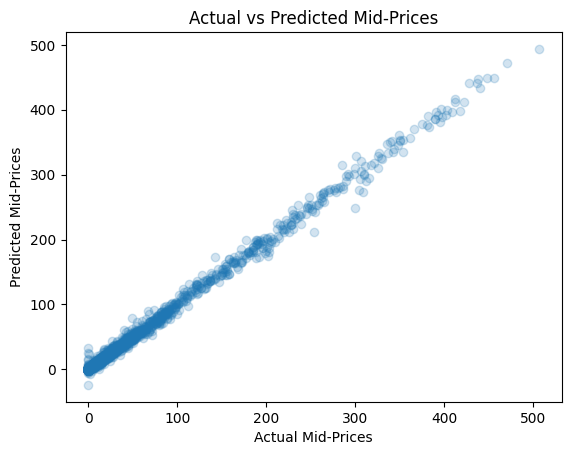

Mean squared error of test set: 9.6815022703375
Mean absolute error of test set: 1.3597225152182335


In [16]:
index = range(0, len(y_test))
for pred in y_pred:
    plt.scatter(y_test, pred, alpha=0.2)
    plt.xlabel("Actual Mid-Prices")
    plt.ylabel("Predicted Mid-Prices")
    plt.title('Actual vs Predicted Mid-Prices')
    plt.show()
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    print(f'Mean squared error of test set: {mse}')
    print(f'Mean absolute error of test set: {mae}')

The visible MSE and MAE for two of the *n_estimators* is visibly identical, and as such, implies that there may be a problem with the parameter *n_iter_o_change*. In conjunction with the small difference in MSE, and especially MAE with 120 *n_estimators* compared to 668 *n_estimators*, this is supported further. 

## Best Model

In [20]:
best_model_mse = GradientBoostingRegressor(max_depth=5, 
                                           learning_rate=0.5,
                                           n_estimators=668, 
                                           n_iter_no_change=5,
                                           random_state=42)
%time best_model_mse.fit(X_train, y_train)

y_pred = best_model_mse.predict(X_test)

CPU times: total: 10.4 s
Wall time: 10.5 s


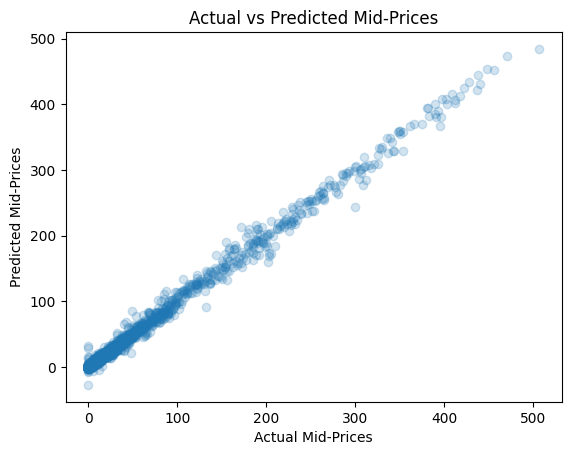

In [21]:
index = range(0, len(y_test))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel("Actual Mid-Prices")
plt.ylabel("Predicted Mid-Prices")
plt.title('Actual vs Predicted Mid-Prices')
plt.show()

In [22]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error of test set: {mse}')
print(f'Mean absolute error of test set: {mae}')

Mean squared error of test set: 15.217154012619384
Mean absolute error of test set: 1.8057905861580072


Based on the results, I think it's very possible the model is overfitting, especially given the more miniscule changes in the MSE and MAE, and indeed Gradient Boosting has more hyperparameters that could be changed, and more fitting that can be done to provide a better model, beyond what's shown in this report. However, given what's shown, Gradient Boost could potentially make a decent model for option prediction, but more work would be needed to say for certain. However, in comparison to other models, the MSE and MAE are much larger, marking Gradient Boosting as a potentially bad algorithm to use for this kind of application.

----

# Jasmine's Model - K-NN Regression

--

# Model Selection

For this task, I decided to use a K-NN regressor for its simplicity and speed, and its ability to work well with enough well-engineered feature data. Furthermore, despite being relatively lightweight and simple, it can still model nonlinear relationships; although, it's not great at extrapolation and is slow for large datasets. To try and increase the model's speed on our large dataset, I first apply PCA to reduce the dimensionality of the dataset before training the model.

I selected the K-NN regressor for several reasons:
1. K-NN is a non-parametric model, which is useful in American option pricing where no assumptions about the underlying functional form of the data is a benefit. Since the payoff structure and early exercise features introduce nonlinear and path-dependent behaviors that are often difficult to model with traditional linear models, a non-parametric model like K-NN could improve price prediction performance.
2. K-NN leverages the local similarity between features and makes predictions based on neighboring historical points. This local interpolation approach is effective in financial data where similar market conditions often result in similar pricing behavior.
3. K-NN is simple to implement, interpretable, and robust to noisy targets, which are all beneficial in modeling complex financial dynamics. It's also multivariate and can, as stated above, handle nonlinear interactions between features without needing to explicitly model them.

Some drawdowns are:
1. K-NN can be computationally expensive and slow, especially for large datasets
2. It performs poorly with irrelevant or redundant features
3. It does not extrapolate well outside the training data

To address these concerns, I:
1. Will use PCA to reduce the dimensionality of the dataset before training the K-NN model to improve both speed and generalization performance.
2. Tune the hyperparameters (using RandomizedSearchCV) to carefully optimize the parameters in a way that ensures the model is more aptly fit for the structure of the feature space.

In summary, while K-NN is a relatively simple model, it has advantages in its combination of speed, interpretability, and flexibility make it a strong base model especially when paired with preprocessing methods like PCA and hyperparameter tuning.

# Base K-NN Regression Call Option Model (No Hyperparameter Tuning)

Pipeline Design:
1. Numerical pipeline
    * SimpleImputer with median imputation is robust to outliers, which is better suited for clearning financial or pricing data
    * StandardScaler ensures all numeric features have mean 0 and unit variance, which is important for distance-based models like K-NN
    * PCA (retaining 95% variance) to avoid curse of dimensionality and reduce model runtime
2. Categorical Pipeline:
    * SimpleImputer replaces missing values with most frequent category to avoid data leakage and retain most common patterns in the data
    * OneHotEncoder to encode categorical variables into binary values, which is necessary for a model like K-NN that cannot handle non-numeric inputs.

Metric:
1. RMSE to measure prediction accuracy while penalizing large errors more heavily, well-suited for our problem of mid-price forecasting. However, it can also exaggerate the impact of outliers.
2. MAE to give a second metric that is more robust to outliers and a more interpretable measure of average prediction error especially when dealing with the same units (e.g. we're using dollars to predict mid-prices, and that unit stays the same).

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
import numpy as np
import matplotlib.pyplot as plt


# Identifying column types for preprocessing
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()


# Define preprocessing pipelines for numerical and categorical features
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))  # PCA to reduce dimensionality while retaining 95% variance
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

# Fit the full pipeline
pipeline.fit(X_train, y_train)

# Predict and evaluate using RMSE
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test RMSE (with PCA): {np.sqrt(mse):.4f}")
print(f"Test MAE (with PCA): {mae:.4f}")


# Plot the actuals v.s. predicted values to determine if model is over/under-fitting -------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Mid Price")
plt.ylabel("Predicted Mid Price")
plt.title("Actual vs Predicted Mid Price (No Tuning)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot the validation and training learning curve -------

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_test)

y_val = y_test.values

# STEP 2: Loop through training set sizes
train_sizes = np.linspace(0.1, 1.0, 10)
train_errors = []
val_errors = []

for size in train_sizes:
    subset_size = int(size * len(X_train_preprocessed))
    
    X_subset = X_train_preprocessed[:subset_size]
    y_subset = y_train[:subset_size]

    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_subset, y_subset)

    y_train_pred = knn.predict(X_subset)
    y_val_pred = knn.predict(X_val_preprocessed)

    train_rmse = np.sqrt(mean_squared_error(y_subset, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

# STEP 3: Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes * len(X_train_preprocessed), train_errors, label='Training RMSE', marker='o')
plt.plot(train_sizes * len(X_train_preprocessed), val_errors, label='Validation MSE', marker='s')
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.title("K-NN Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# K-NN Regression Call Option Model with Hyperparameter Tuning (explain more)

In this section, we will use RandomizedSearchCV to tune our model's hyperparameters and note any improvements in performance. We use RandomizedSearchCV over GridSearchCV for faster search time over our larger search space. n_neighbors range is set 3 to 30. Low k's (3-5) cause the model to become highly flexible and prone to overfitting to noise in training data. High k's (>20) lead to more stable models (less variance), but it may underfit by averaging over too many points. Having this range balances the bias-variance tradeoff and allows the tuning process to find an optimal k that generalizes well without over or under-fitting. The weighting scheme is split between uniform and distance, allowing the model to explore different ways of weighing the neighbors depending on the data distribution. It would allow the model to adapt to different levels of locality sensitivity in option prices. Lastly, we allow the search to choose between which of the two common distance metrics is most appropriate to the data.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


param_dist = {
    'knn__n_neighbors': randint(3, 30),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2],  # 1=Manhattan, 2=Euclidean
}

random_search_mse = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search_mse.fit(X_train, y_train)

print("Best parameters found:", random_search_mse.best_params_)
print("Best CV RMSE:", np.sqrt(-random_search_mse.best_score_))

# Use the best model for prediction
best_knn_model = random_search_mse.best_estimator_
y_pred = best_knn_model.predict(X_test)

best_params = random_search_mse.best_params_
best_k = best_params['knn__n_neighbors']
best_weights = best_params['knn__weights']
best_p = best_params['knn__p']

# Store training and validation scores to plot
y_train_pred = best_knn_model.predict(X_train)
y_valid_pred = best_knn_model.predict(X_valid)


mse = mean_squared_error(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))
print(f"Test RMSE with best parameters: {np.sqrt(mse):.4f}")
print(f"Test MAE with best parameters: {mae:.4f}")


# Plot the actuals v.s. predicted values -------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Mid Price")
plt.ylabel("Predicted Mid Price")
plt.title("Actual vs Predicted Mid Price (Hyperaparameter Tuning)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot the validation and training learning curve -------

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_test)

y_val = y_test.values

train_sizes = np.linspace(0.1, 1.0, 10)
train_errors = []
val_errors = []

for size in train_sizes:
    subset_size = int(size * len(X_train_preprocessed))
    
    X_subset = X_train_preprocessed[:subset_size]
    y_subset = y_train[:subset_size]

    best_knn = KNeighborsRegressor(n_neighbors=best_k, weights=best_weights, p=best_p)  # Use the best KNN model from the random search
    best_knn.fit(X_subset, y_subset)

    y_train_pred = best_knn.predict(X_train_preprocessed)
    y_val_pred = best_knn.predict(X_val_preprocessed)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

# STEP 3: Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes * len(X_train_preprocessed), train_errors, label='Training RMSE', marker='o')
plt.plot(train_sizes * len(X_train_preprocessed), val_errors, label='Validation MSE', marker='s')
plt.xlabel("Training Set Size")
plt.ylabel("Root Mean Squared Error")
plt.title("K-NN Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



----

# Conclusions